In [1]:
!pip install pyconll

In [2]:
!git clone https://github.com/UniversalDependencies/UD_Arabic-PADT

Cloning into 'UD_Arabic-PADT'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 595 (delta 19), reused 24 (delta 9), pack-reused 560
Receiving objects: 100% (595/595), 121.10 MiB | 30.25 MiB/s, done.
Resolving deltas: 100% (428/428), done.


In [227]:
import numpy as np
import pyconll
from matplotlib import pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam,SGD
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard,ReduceLROnPlateau
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import gensim
import re
import itertools
from nltk import ngrams
import warnings
warnings.filterwarnings('ignore')

In [3]:
UD_Arabic_TRAIN = '/content/UD_Arabic-PADT/ar_padt-ud-train.conllu'
UD_Arabic_DEV = '/content/UD_Arabic-PADT/ar_padt-ud-dev.conllu'
UD_Arabic_TEST = '/content/UD_Arabic-PADT/ar_padt-ud-test.conllu'

In [4]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

In [7]:
train_sentences = read_conllu(UD_Arabic_TRAIN)
val_sentences = read_conllu(UD_Arabic_DEV)
test_sentences = read_conllu(UD_Arabic_TEST)

In [8]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  6075
Tagged words in train set: 223881
Tagged sentences in dev set:  909
Tagged words in dev set: 30239
Tagged sentences in test set:  680
Tagged words in test set: 28264
****************************************
Total sentences in dataset: 7664


In [9]:
print(train_sentences[0])

[('برلين', 'X'), ('ترفض', 'VERB'), ('حصول', 'NOUN'), ('شركة', 'NOUN'), ('اميركية', 'ADJ'), ('على', 'ADP'), ('رخصة', 'NOUN'), ('تصنيع', 'NOUN'), ('دبابة', 'NOUN'), ('"', 'PUNCT'), ('ليوبارد', 'X'), ('"', 'PUNCT'), ('الالمانية', 'ADJ')]


In [10]:
def tag_sequence(sentences):
    return [[tag for word, tag in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[word for word, tag in sentence] for sentence in sentences]

In [11]:
tags = set([item for sublist in train_sentences+test_sentences+val_sentences for _, item in sublist])
print('TOTAL TAGS: ', len(tags))

TOTAL TAGS:  17


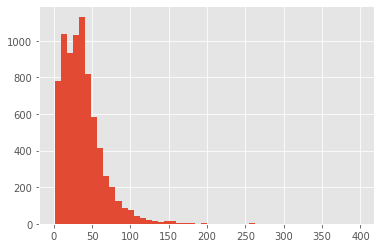

In [228]:
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [13]:
print('Max sentence length:',len(max(train_sentences+val_sentences, key=len)))

Max sentence length: 398



To avoid truncating sequences during padding we split our sentences to MAX_SEQUENCE_LENGTH. For example, if MAX_SEQUENCE_LENGTH=70, a sentence with length 150 splits in 3 sentences: 150=70+70+10

In [ ]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new

In [ ]:
MAX_SEQUENCE_LENGTH = 70

train_sentences = split(train_sentences, MAX_SEQUENCE_LENGTH)
val_sentences = split(val_sentences, MAX_SEQUENCE_LENGTH)
test_sentences = split(test_sentences, MAX_SEQUENCE_LENGTH)

In [14]:
train_sentences[0]

[('برلين', 'X'),
 ('ترفض', 'VERB'),
 ('حصول', 'NOUN'),
 ('شركة', 'NOUN'),
 ('اميركية', 'ADJ'),
 ('على', 'ADP'),
 ('رخصة', 'NOUN'),
 ('تصنيع', 'NOUN'),
 ('دبابة', 'NOUN'),
 ('"', 'PUNCT'),
 ('ليوبارد', 'X'),
 ('"', 'PUNCT'),
 ('الالمانية', 'ADJ')]

In [15]:
train_sentences = train_sentences + val_sentences + test_sentences

In [16]:
train_text = text_sequence(train_sentences)
train_tags = tag_sequence(train_sentences)

In [17]:
len(train_text)

7664

In [18]:
train_text[0], train_tags[0]

(['برلين',
  'ترفض',
  'حصول',
  'شركة',
  'اميركية',
  'على',
  'رخصة',
  'تصنيع',
  'دبابة',
  '"',
  'ليوبارد',
  '"',
  'الالمانية'],
 ['X',
  'VERB',
  'NOUN',
  'NOUN',
  'ADJ',
  'ADP',
  'NOUN',
  'NOUN',
  'NOUN',
  'PUNCT',
  'X',
  'PUNCT',
  'ADJ'])

In [88]:
embedding_dim = 300
MAX_SEQUENCE_LENGTH = 398
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [89]:
word_tokenizer = Tokenizer(oov_token = oov_tok)                    
word_tokenizer.fit_on_texts(train_text)  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1                  
X_encoded_train = word_tokenizer.texts_to_sequences(train_text)  

In [174]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_tags)
Y_encoded_train = tag_tokenizer.texts_to_sequences(train_tags)

In [91]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', train_text[0], '\n')
print('Y: ', train_tags[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded_train[0], '\n')
print('Y: ', Y_encoded_train[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية'] 

Y:  ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [3936, 2492, 971, 89, 2082, 12, 3937, 1966, 3582, 10, 4888, 10, 1967] 

Y:  [7, 5, 1, 1, 3, 2, 1, 1, 1, 4, 7, 4, 3] 



In [92]:
X_padded_train = pad_sequences(X_encoded_train, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
Y_padded_train = pad_sequences(Y_encoded_train, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)

X_train = X_padded_train
Y_train = Y_padded_train

In [93]:
X_train.shape

(7664, 398)

In [94]:
Y_train = to_categorical(Y_train)

In [95]:
Y_train.shape

(7664, 398, 18)

In [96]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.15, random_state=41)

In [97]:
X_train, X_valid , Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 41)

In [98]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_valid.shape))
print('Shape of output sequences: {}'.format(Y_valid.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (5536, 398)
Shape of output sequences: (5536, 398, 18)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (978, 398)
Shape of output sequences: (978, 398, 18)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (1150, 398)
Shape of output sequences: (1150, 398, 18)


In [99]:
NUM_CLASSES = Y_train.shape[2]
NUM_CLASSES

18

In [100]:
model = Sequential()
model.add(InputLayer((MAX_SEQUENCE_LENGTH)))
model.add(Embedding(input_dim = VOCABULARY_SIZE,
                             output_dim    = embedding_dim,
                             input_length  = MAX_SEQUENCE_LENGTH,
                             trainable     = True
))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 398, 300)          7471800   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 398, 512)          1140736   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 398, 512)          1574912   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 398, 512)          1574912   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 398, 512)          1574912   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 398, 18)           9234      
Total params: 13,346,506
Trainable params: 13,346,506
Non-trainable params: 0
__________________________________________

In [102]:
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min' , min_lr=0.0001)

In [103]:
result = model.fit(X_train, Y_train, validation_data= (X_valid, Y_valid), epochs = 40, batch_size= 128, shuffle = True,callbacks=[checkpoint,reducelr])

Epoch 1/40
44/44 [==============================] - 51s 897ms/step - loss: 0.6803 - accuracy: 0.8301 - val_loss: 0.1984 - val_accuracy: 0.9386

Epoch 00001: val_accuracy improved from -inf to 0.93864, saving model to model_checkpoint.h5
Epoch 2/40
44/44 [==============================] - 36s 818ms/step - loss: 0.1955 - accuracy: 0.9388 - val_loss: 0.1877 - val_accuracy: 0.9392

Epoch 00002: val_accuracy improved from 0.93864 to 0.93922, saving model to model_checkpoint.h5
Epoch 3/40
44/44 [==============================] - 36s 813ms/step - loss: 0.1833 - accuracy: 0.9399 - val_loss: 0.1761 - val_accuracy: 0.9415

Epoch 00003: val_accuracy improved from 0.93922 to 0.94148, saving model to model_checkpoint.h5
Epoch 4/40
44/44 [==============================] - 36s 819ms/step - loss: 0.1652 - accuracy: 0.9444 - val_loss: 0.1409 - val_accuracy: 0.9526

Epoch 00004: val_accuracy improved from 0.94148 to 0.95258, saving model to model_checkpoint.h5
Epoch 5/40
44/44 [=========================

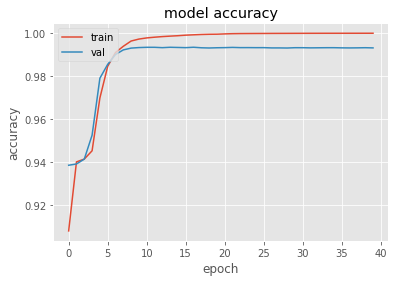

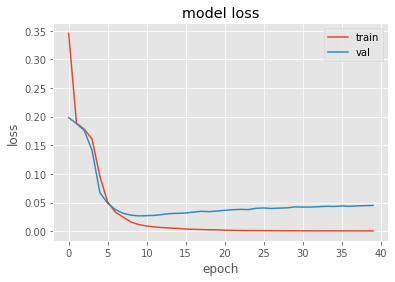

In [104]:
#Plot Accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

#Plot Loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.show()

In [105]:
model.load_weights('model_checkpoint.h5')

In [106]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

36/36 [==============================] - 4s 104ms/step - loss: 0.0348 - accuracy: 0.9930
Loss: 0.03484053164720535,
Accuracy: 0.9930369257926941


In [107]:
def classify(sentence):
  sentence = sentence.split()
  seq = [word_tokenizer.texts_to_sequences(sentence)]
  pad_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
  pad_seq = np.squeeze(pad_seq,axis=-1)
  pred = np.squeeze(model.predict(pad_seq).argmax(-1))
  output = [tag_tokenizer.index_word[tag] for tag in pred if tag != 0]
  return output

In [110]:
sentence = "محمد ذهب الى المسجد ليصلى العشاء"
output = classify(sentence)
word_tag = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
print(word_tag)

[('محمد', 'x'), ('ذهب', 'verb'), ('الى', 'adp'), ('المسجد', 'noun'), ('ليصلى', 'adj'), ('العشاء', 'noun')]


In [322]:
Y_test_plot = Y_test.argmax(-1)
pred = np.squeeze(model.predict(X_test).argmax(-1))
print(Y_test_plot.shape)
print(pred.shape)

(1150, 398)
(1150, 398)


In [323]:
tag_names = tag_tokenizer.index_word.copy()
tag_names[0] = 'padded with zero'
cm_target_names = [tag_names[i] for i in range(18)]

In [324]:
name='Bi-LSTM Model'
print('\n------------ Result of {} ----------\n'.format(name))
print(classification_report(Y_test_plot.flatten(), pred.flatten(),digits=4,target_names=cm_target_names))


------------ Result of Bi-LSTM Model ----------

                  precision    recall  f1-score   support

padded with zero     1.0000    1.0000    1.0000    415495
            noun     0.9629    0.9245    0.9433     13928
             adp     0.9872    0.9951    0.9911      6350
             adj     0.6834    0.9551    0.7967      4300
           punct     0.9982    0.9997    0.9990      3409
            verb     0.9502    0.8601    0.9029      3217
           cconj     0.9945    0.9888    0.9917      2952
               x     0.8361    0.5909    0.6924      2564
            pron     0.9796    0.9857    0.9826      1607
             num     0.9850    0.8861    0.9329      1185
             det     0.9491    0.9511    0.9501       941
           sconj     0.9584    0.9926    0.9752       813
            part     0.9195    0.8743    0.8964       366
             aux     0.8424    0.8081    0.8249       344
             adv     0.8741    0.8489    0.8613       139
             sym     

In [325]:
def plot_cm(f1,cm,target_names,title='Confusion matrix',cmap=None,normalize=True,i=1):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(14, 14))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            if i == j:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),fontsize=11,
                     horizontalalignment="center",weight='bold',
                     color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),fontsize=11,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            if i == j:
                plt.text(j, i, "{:,}".format(cm[i, j]),fontsize=11,
                     horizontalalignment="center",weight='bold',
                     color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),fontsize=11,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

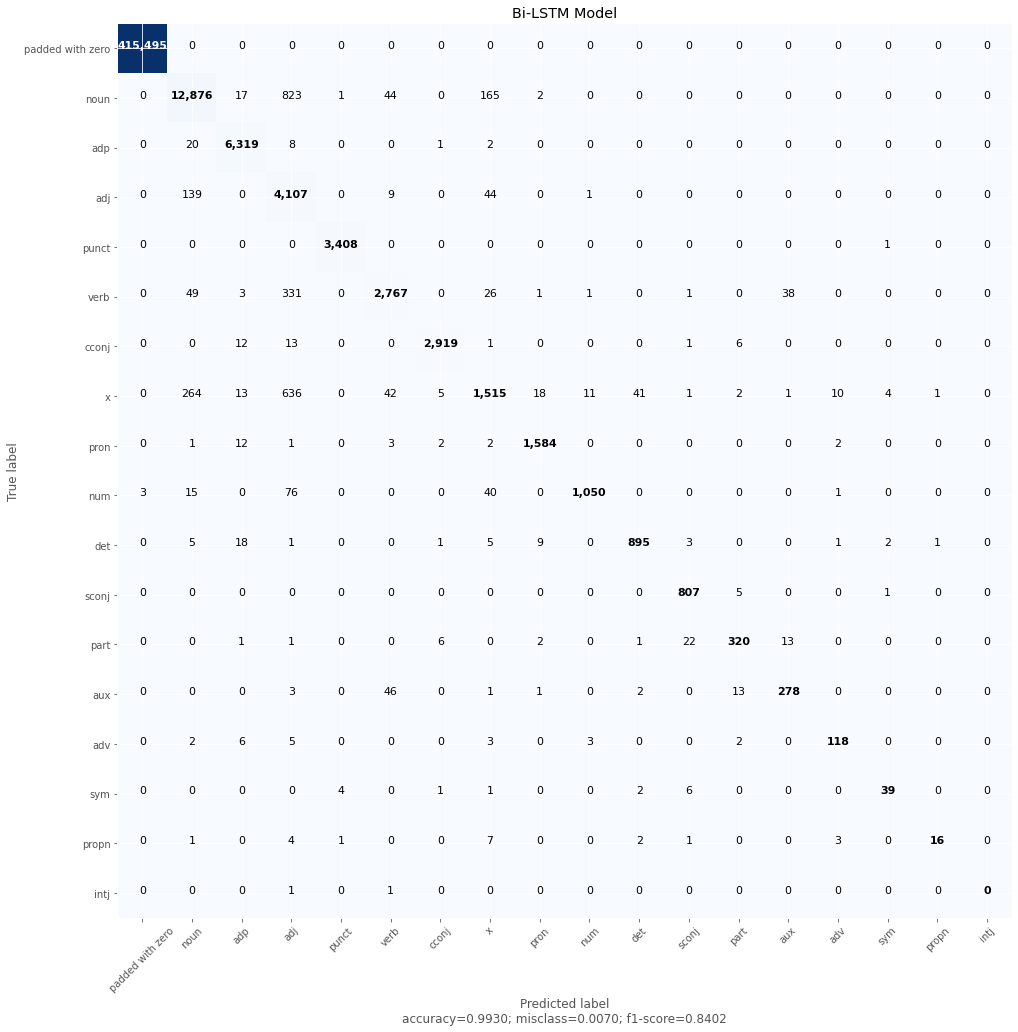

In [326]:
cnf_matrix = confusion_matrix(Y_test_plot.flatten(), pred.flatten())
plot_cm(f1_score(Y_test_plot.flatten(), pred.flatten(), average='macro'), cnf_matrix, target_names=cm_target_names, title=name, normalize=False)